# [Lab Session 4](deconvolution.ipynb)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.restoration import wiener
from scipy.signal import convolve2d as conv
from scipy.stats import multivariate_normal as multi_normal

np.random.seed(0)

Load the image.

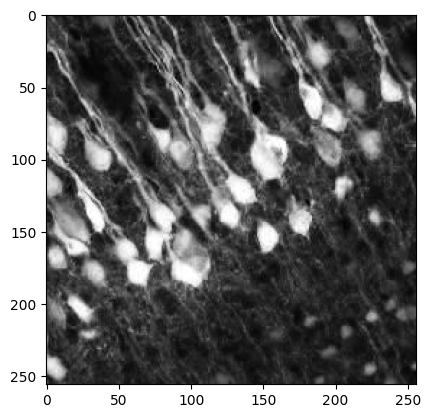

In [2]:
img = plt.imread('data/cells.png')[128:384, 128:384]
plt.imshow(img, 'gray')

**[Task 1.]()** Apply the following PSF to the image and then display it.

In [3]:
psf_size = 10
psf = np.ones((psf_size, psf_size)) / psf_size ** 2

In [5]:
img_blur = conv(img, psf, mode='same', boundary='symm')

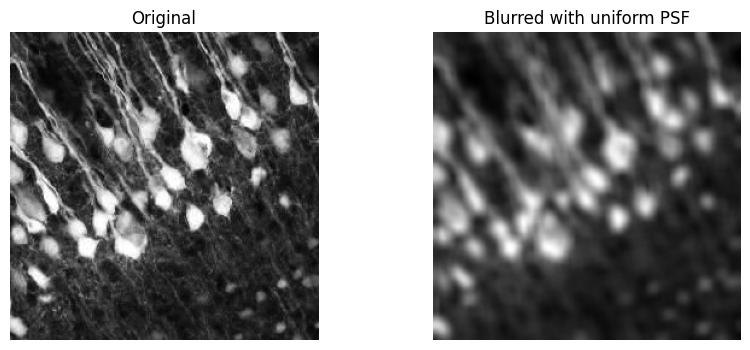

In [7]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_blur, cmap='gray')
plt.title("Blurred with uniform PSF")
plt.axis('off')

plt.show()

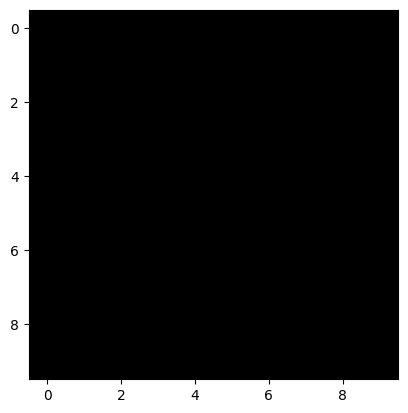

In [10]:
plt.imshow(psf,'gray')

**[Task 2.]()** Have a look at the Gaussian PSF which is not uniformly distributed. Apply it to the image.

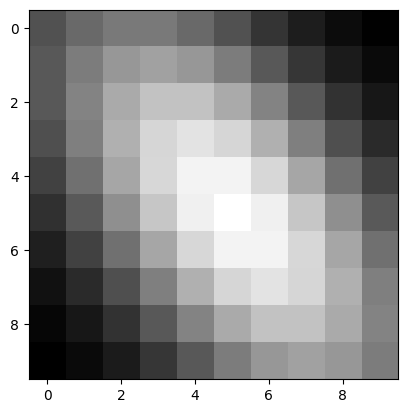

In [8]:
def create_psf(size):
    factor = size * 1.8
    x, y = np.mgrid[0:size:1, 0:size:1]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x
    pos[:, :, 1] = y
    rv = multi_normal([int(size / 2), (int(size / 2))], [[factor * 1., factor * 1.2], [factor * .5, factor * .7]])
    return rv.pdf(pos)

plt.imshow(create_psf(psf_size), 'gray')

Apply the second psf to the image:

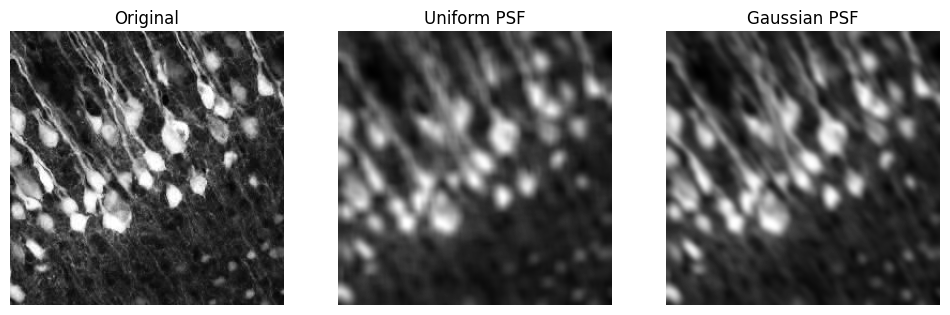

In [11]:
# Step 1: 创建 Gaussian PSF
psf_gaussian = create_psf(psf_size)

# Step 2: 归一化（避免图像变亮）
psf_gaussian = psf_gaussian / psf_gaussian.sum()

# Step 3: 卷积
img_gauss_blur = conv(img, psf_gaussian, mode='same', boundary='symm')

# Step 4: 显示结果
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(img_blur, cmap='gray')   # uniform PSF 结果（Task 1）
plt.title("Uniform PSF")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(img_gauss_blur, cmap='gray')
plt.title("Gaussian PSF")
plt.axis('off')

plt.show()


**[Task 3.]()** Implement a reusable function that performs the Richardson-Lucy deconvolution.

In [ ]:
def richardson_lucy_deconvolution(image, psf, n_iterations):
    img_deconv = np.full(image.shape, 0.5)
    
    ### Insert code here
    
    img_deconv = img_deconv.clip(0,1)
    return img_deconv

**[Task 4.]()** Apply the Richardson-Lucy deconvolution to the blurred image.

In [12]:
def richardson_lucy(g, psf, iterations=20):
    # 1. 初始化 h（与 g 同尺寸，值都为 0.5）
    h = np.full_like(g, 0.5, dtype=float)

    # 2. 翻转 PSF（P*）
    psf_flipped = np.flip(psf, axis=(0,1))

    for t in range(iterations):
        # (a) 计算 h(t) * P
        conv_h = conv(h, psf, mode='same', boundary='symm')

        # (b) 避免除零
        conv_h = np.maximum(conv_h, 1e-12)

        # (c) 比值 g / (h(t) * P)
        ratio = g / conv_h

        # (d) ratio * P*
        correction = conv(ratio, psf_flipped, mode='same', boundary='symm')

        # (e) 更新 h(t+1)
        h = h * correction

    return h


In [25]:
# g = 模糊后的图像（例如 uniform 或 Gaussian blur 后的 img_blur）
# psf = 你 blur 时使用的 PSF（uniform 或 gaussian）

deconv_img = richardson_lucy(img_blur, psf_gaussian, iterations=20)

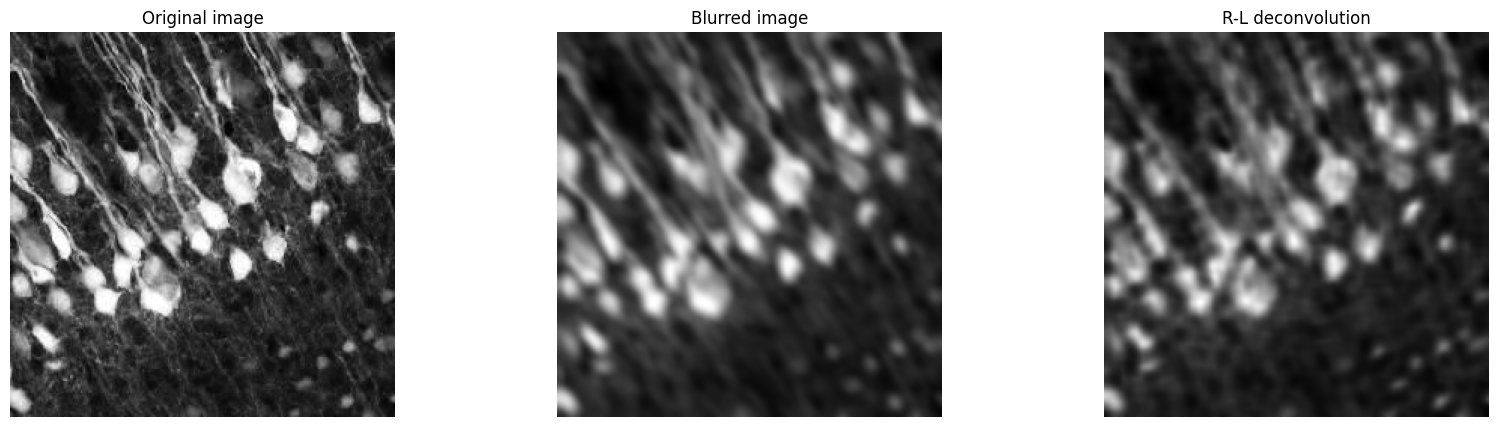

In [26]:
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(img, 'gray')
plt.title('Original image')
plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(img_gauss_blur, 'gray')
plt.title('Blurred image')
plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(deconv_img, 'gray')
plt.title('R-L deconvolution')
plt.show()

**[Task 5.]()** Add noise to the image, use the R-L deconvolution again.

In [22]:
noise = (np.random.normal(loc=0,size=img.shape))
reduce_factor = 5
noise = noise / reduce_factor

In [23]:
# Step 2: 加噪声到模糊图像（例如 Gaussian PSF blur）
noisy_img = img_gauss_blur + noise

# Step 3: clip 到合法范围 0~1
noisy_img = np.clip(noisy_img, 0, 1)

# Step 4: 对 noisy 图像再做 R-L
deconv_noisy = richardson_lucy(noisy_img, psf_gaussian, iterations=20)

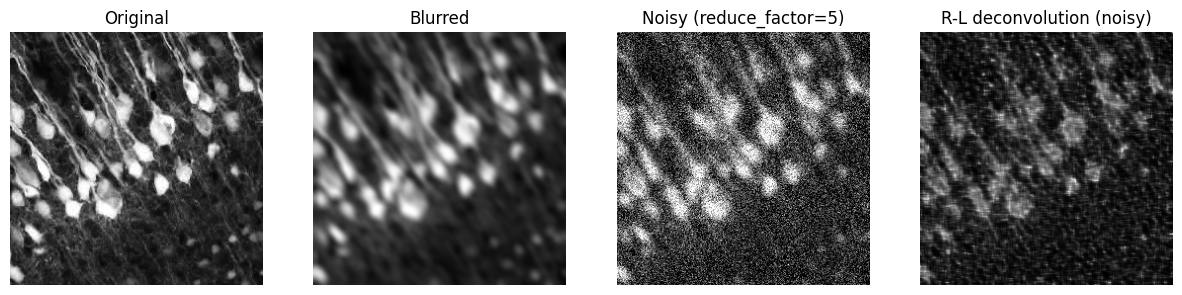

In [24]:
# Step 5: 展示对比
plt.figure(figsize=(15,4))

plt.subplot(1,4,1)
plt.imshow(img, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(img_gauss_blur, cmap='gray')
plt.title("Blurred")
plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(noisy_img, cmap='gray')
plt.title(f"Noisy (reduce_factor={reduce_factor})")
plt.axis('off')

plt.subplot(1,4,4)
plt.imshow(deconv_noisy, cmap='gray')
plt.title("R-L deconvolution (noisy)")
plt.axis('off')

plt.show()

**[Task 6.]()** Compare your R-L implementation to a wiener deconvolution.

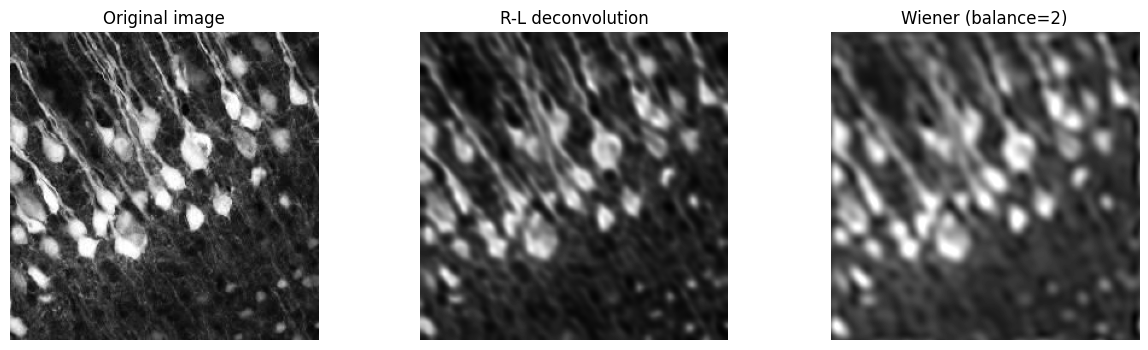

In [30]:
# -----------------------------
# R-L reconstruction
# -----------------------------
deconv_rl = richardson_lucy(img_gauss_blur, psf_gaussian, iterations=20)

# -----------------------------
# Wiener reconstruction
# -----------------------------
balance = 2 # you can try balance = 0.1, 1, 2, 5, 10
deconv_wiener = wiener(img_gauss_blur, psf_gaussian, balance=balance, clip=True)


# -----------------------------
# Display results
# -----------------------------
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.title('Original image')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(deconv_rl, cmap='gray')
plt.title('R-L deconvolution')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(deconv_wiener, cmap='gray')
plt.title(f'Wiener (balance={balance})')
plt.axis('off')

plt.show()


In [33]:
# 1. 生成噪声并加到模糊图像上
noise = np.random.normal(loc=0, size=img.shape)
reduce_factor = 5        # 调噪声强度：1 噪声大，10 噪声小
noise = noise / reduce_factor

noisy_img = img_gauss_blur + noise

# 2. 限制到 [0, 1]
noisy_img = np.clip(noisy_img, 0, 1)

# R-L 去卷积（对 noisy 图）
deconv_rl_noisy = richardson_lucy(noisy_img, psf_gaussian, iterations=20)

# Wiener 去卷积（对 noisy 图）
balance = 2  # 建议从 0.05, 0.1, 0.2, 0.5, 1 试起
deconv_wiener_noisy = wiener(noisy_img, psf_gaussian,
                             balance=balance, clip=True)


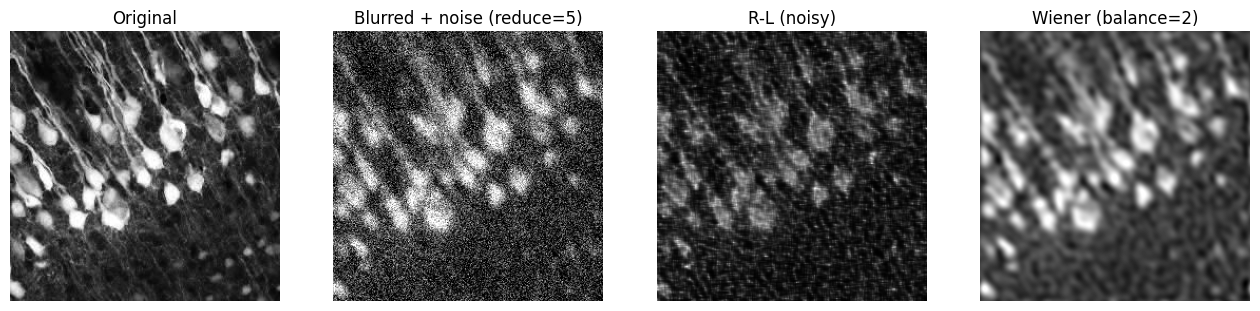

In [34]:
plt.figure(figsize=(16,4))

plt.subplot(1,4,1)
plt.imshow(img, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(noisy_img, cmap='gray')
plt.title(f'Blurred + noise (reduce={reduce_factor})')
plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(deconv_rl_noisy, cmap='gray')
plt.title('R-L (noisy)')
plt.axis('off')

plt.subplot(1,4,4)
plt.imshow(deconv_wiener_noisy, cmap='gray')
plt.title(f'Wiener (balance={balance})')
plt.axis('off')

plt.show()


**[Task 7.]()** Repeat Tasks 4–6 using a smaller value for the size of the PSF.

**[Task 8.]()** Use a wrong PSF to restore the image